# Intro
In this notebook we explore the FD001 dataset. We'll re-examine our assumption of RUL and fit an SVR to get a better score.
  

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
os.getcwd()

'd:\\Ineuron Internship\\Predictive Maintainance\\predictive_maintainance_project\\Analysis'

In [3]:
pred = pd.read_csv('D:\\Ineuron Internship\\Predictive Maintainance\\predictive_maintainance_project\\Prediction_Output_File/Predictions.csv')

## Load data and compute RUL

In [6]:
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


## Re-examine RUL

Our current assumption of RUL for the train set is that it declines linearly to zero. However, when we inspect the sensor signals they often show a 'bend' in their curve indicating degradation has started. Based on the information given to us we can't really say anything about RUL before this point, as we don't have any information on initial wear and tear of the engines.

Therefore, we assume RUL to start out constant and only decline linearly after some time. The aim is to get a similar 'bend' in the curve (see image below).
Starting out with a constant RUL achieves two things:  
1) Initially constant RUL correlates better with the stable mean sensor signal  
2) Lower peak values of RUL results in lower spread of our target variable, making it easier to fit a line

In [8]:
clipped_rul = train.loc[train['unit_nr']==20].copy()
clipped_rul

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
3934,20,1,0.0023,0.0002,100.0,518.67,643.00,1589.87,1404.30,14.62,...,2388.02,8136.61,8.4498,0.03,391,2388,100.0,38.88,23.2767,233
3935,20,2,0.0002,0.0000,100.0,518.67,642.72,1588.75,1406.60,14.62,...,2388.06,8136.47,8.4217,0.03,393,2388,100.0,38.79,23.2626,232
3936,20,3,-0.0010,-0.0001,100.0,518.67,642.90,1587.31,1404.30,14.62,...,2388.07,8136.89,8.4432,0.03,391,2388,100.0,38.79,23.2760,231
3937,20,4,0.0013,-0.0000,100.0,518.67,642.42,1583.00,1417.06,14.62,...,2388.09,8133.40,8.4390,0.03,393,2388,100.0,38.87,23.2784,230
3938,20,5,-0.0009,-0.0003,100.0,518.67,642.55,1585.71,1406.90,14.62,...,2388.09,8135.61,8.4171,0.03,392,2388,100.0,38.88,23.2748,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163,20,230,-0.0010,-0.0000,100.0,518.67,643.57,1605.67,1431.45,14.62,...,2388.24,8144.08,8.4887,0.03,396,2388,100.0,38.60,23.1231,4
4164,20,231,0.0022,-0.0003,100.0,518.67,643.89,1603.35,1429.72,14.62,...,2388.22,8146.48,8.4800,0.03,397,2388,100.0,38.74,22.9885,3
4165,20,232,-0.0003,0.0000,100.0,518.67,643.85,1608.02,1432.08,14.62,...,2388.29,8139.51,8.5230,0.03,397,2388,100.0,38.33,23.1460,2
4166,20,233,-0.0012,-0.0001,100.0,518.67,643.93,1601.90,1437.23,14.62,...,2388.23,8143.94,8.5058,0.03,396,2388,100.0,38.46,22.9783,1


In [9]:
clipped_rul['RUL'].clip(upper=125, inplace=True)
clipped_rul

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
3934,20,1,0.0023,0.0002,100.0,518.67,643.00,1589.87,1404.30,14.62,...,2388.02,8136.61,8.4498,0.03,391,2388,100.0,38.88,23.2767,125
3935,20,2,0.0002,0.0000,100.0,518.67,642.72,1588.75,1406.60,14.62,...,2388.06,8136.47,8.4217,0.03,393,2388,100.0,38.79,23.2626,125
3936,20,3,-0.0010,-0.0001,100.0,518.67,642.90,1587.31,1404.30,14.62,...,2388.07,8136.89,8.4432,0.03,391,2388,100.0,38.79,23.2760,125
3937,20,4,0.0013,-0.0000,100.0,518.67,642.42,1583.00,1417.06,14.62,...,2388.09,8133.40,8.4390,0.03,393,2388,100.0,38.87,23.2784,125
3938,20,5,-0.0009,-0.0003,100.0,518.67,642.55,1585.71,1406.90,14.62,...,2388.09,8135.61,8.4171,0.03,392,2388,100.0,38.88,23.2748,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163,20,230,-0.0010,-0.0000,100.0,518.67,643.57,1605.67,1431.45,14.62,...,2388.24,8144.08,8.4887,0.03,396,2388,100.0,38.60,23.1231,4
4164,20,231,0.0022,-0.0003,100.0,518.67,643.89,1603.35,1429.72,14.62,...,2388.22,8146.48,8.4800,0.03,397,2388,100.0,38.74,22.9885,3
4165,20,232,-0.0003,0.0000,100.0,518.67,643.85,1608.02,1432.08,14.62,...,2388.29,8139.51,8.5230,0.03,397,2388,100.0,38.33,23.1460,2
4166,20,233,-0.0012,-0.0001,100.0,518.67,643.93,1601.90,1437.23,14.62,...,2388.23,8143.94,8.5058,0.03,396,2388,100.0,38.46,22.9783,1


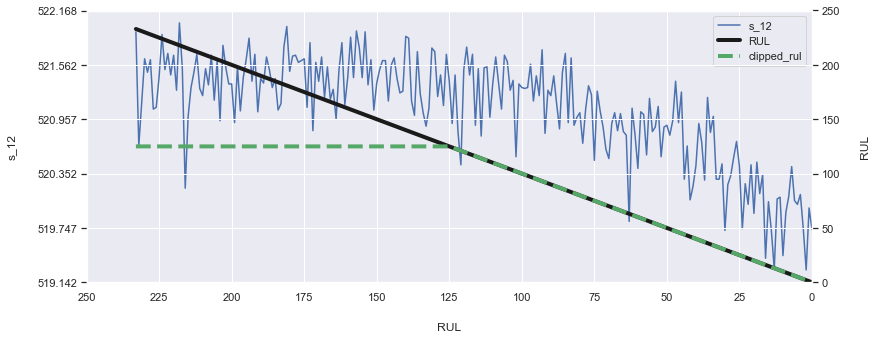

In [10]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot('RUL', 's_12', 'b',
                 data=train.loc[train['unit_nr']==20])
plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('s_12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot('RUL', 'RUL', 'k', linewidth=4,
                   data=train.loc[train['unit_nr']==20])
rul = train.loc[train['unit_nr']==20, 'RUL']
rul_line2 = ax2.plot(rul, rul.where(rul <= 125, 125), '--g', linewidth=4, label='clipped_rul')  # SET LABEL MANUALLY?
ax2.set_ylabel('RUL', labelpad=20)

# code to have equal spacing of y ticks for both axes, so the gridlines allign
# from https://stackoverflow.com/questions/20243683/matplotlib-align-twinx-tick-marks?rq=1
ax2.set_ylim(0, 250)  # set limits of axis you want to display neatly
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))  # choose integer to neatly divide your axis, in our case 6
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))  # apply same spacing to other axis


# code to have a unified legend
# from https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = signal+rul_line+rul_line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)

plt.show()

Let's try this out with our baseline model

In [11]:
# prep data
# drop unwanted columns and split target variable from training set
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [12]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [13]:
## Linear declining RUL
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:44.66819159545451, R2:0.5794486527796721
test set RMSE:31.952633027737072, R2:0.40877368076591647


In [14]:
y_train_clipped = y_train.clip(upper=125)

In [15]:
# I previously used the where method, but .clip seems more intuitive
all(y_train.where(y_train <= 125, 125) == y_train_clipped)

True

In [16]:
## Clipped RUL
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)  

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.49101870151526, R2:0.7340432868050485
test set RMSE:21.90021340688863, R2:0.722260819654672


As we've updated our assumption of RUL, I feel this should also be reflected in the train evaluation. The True RUL of the test set remains untouched.  
The train RMSE has more than halved. Of course we've set those targets ourselves, but it still shows how much impact the high 'assumed' RUL values had on overall model performance. Much more imporant tough, is the improvement on the test set (almost one third!). Which informs us the updated assumption is beneficial for modeling true RUL

# SVR

In [17]:
# SVM initial regression + clipped RUL
svr = SVR(kernel='linear')
svr.fit(X_train, y_train_clipped)  

# predict and evaluate
y_hat_train = svr.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:28.39985070962329, R2:0.5355605874043642
test set RMSE:29.332097469202726, R2:0.501773647562729


Results are quite a bit worse, let's try scaling our features to improve model performance

## Scaling

In [18]:
# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
# scaler = StandardScaler()  # for this specific dataset, the type of scaler does not have any effect
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# SVM regression + clipped RUL + scaled
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train_clipped)  

# predict and evaluate
y_hat_train = svr.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE:21.57826397506788, R2:0.7318795396979634
test set RMSE:21.580480163289888, R2:0.7303113540952089


Great, the current RMSE is already an improvement over the baseline regression with clipped RUL. Let's see if we can improve it even further with some feature engineering.

## Feature engineering

In [20]:
# Feature engineering
from sklearn.preprocessing import PolynomialFeatures
# 2nd degree polynomialFeatures of [a, b] becomes [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.fit_transform(X_test_scaled)

print(X_train_scaled.shape)
print(X_train_transformed.shape)

(20631, 14)
(20631, 120)


In [21]:
# SVM regression + clipped RUL + engineered features
svr_f = SVR(kernel='linear')
svr_f.fit(X_train_transformed, y_train_clipped)  

# predict and evaluate
y_hat_train = svr_f.predict(X_train_transformed)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr_f.predict(X_test_transformed)
evaluate(y_test, y_hat_test)

train set RMSE:19.716789731130817, R2:0.7761436785704148
test set RMSE:20.585402508371686, R2:0.754608688211504


## Feature selection

In [27]:
# Feature engineering + selection
from sklearn.feature_selection import SelectFromModel
select_features = SelectFromModel(svr_f, threshold='mean', prefit=True)
select_features.get_support()
feature_names = poly.get_feature_names_out()

print('Original features:\n', X_train.columns)
print('Best features:\n', np.array(feature_names)[select_features.get_support()])
np.array(feature_names)[select_features.get_support()].shape

Original features:
 Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13',
       's_14', 's_15', 's_17', 's_20', 's_21'],
      dtype='object')
Best features:
 ['x0' 'x1' 'x2' 'x3' 'x5' 'x6' 'x7' 'x9' 'x10' 'x11' 'x12' 'x13' 'x2 x5'
 'x2 x8' 'x2 x9' 'x3 x5' 'x3 x8' 'x3 x9' 'x4^2' 'x4 x6' 'x4 x7' 'x4 x8'
 'x5^2' 'x5 x6' 'x5 x7' 'x5 x9' 'x5 x12' 'x5 x13' 'x6^2' 'x6 x8' 'x6 x9'
 'x7 x8' 'x7 x9' 'x8^2' 'x9^2' 'x9 x12' 'x9 x13']


(37,)

In [23]:
# SVM regression + clipped RUL + engineered features + selection
svr = SVR(kernel='linear')
svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped) 

# predict and evaluate
y_hat_train = svr.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

train set RMSE:19.746789101481127, R2:0.7754619593165268
test set RMSE:20.55613819605462, R2:0.7553058913450699


Our feature space went from 14 to 120, after feature selection we're back down to 37 features. These features improved out model yet again.

## Simple hyper parameter tuning

In [24]:
epsilon = [0.4, 0.3, 0.2, 0.1, 0.05]

for e in epsilon:
    svr = SVR(kernel='linear', epsilon=e)
    svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

    # predict and evaluate
    y_hat = svr.predict(X_train_transformed[:, select_features.get_support()])
    mse = mean_squared_error(y_train_clipped, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_train_clipped, y_hat)
    print("epsilon:", e, "RMSE:", rmse, "R2:", variance)

epsilon: 0.4 RMSE: 19.747725566603357 R2: 0.7754406619776463
epsilon: 0.3 RMSE: 19.747580761069845 R2: 0.7754439552496148
epsilon: 0.2 RMSE: 19.746600078171724 R2: 0.7754662580123989
epsilon: 0.1 RMSE: 19.746789101481127 R2: 0.7754619593165268
epsilon: 0.05 RMSE: 19.746532456984017 R2: 0.7754677958176166


An epsilon of 0.2 seems best for our current model, let's train it again and evaluate on the test set for our final RMSE

## Final model

In [25]:
svr = SVR(kernel='linear', epsilon=0.2)
svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

# predict and evaluate
y_hat_train = svr.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

train set RMSE:19.746600078171724, R2:0.7754662580123989
test set RMSE:20.54412482077369, R2:0.75559181500935


The final SVR has a test RMSE of 20.54. The combination of updating our assumption of RUL and fitting an SVR with tuned boundaries, feature scaling and polynomial features provides a 35.7 % improvement over our baseline model (RMSE = 31.95).  

Most of this improvement is attributed to changing our assumption of RUL, which shows the importance of framing your data science problem correctly.

In the next analysis we'll delve into timeseries, see you there!

In [21]:
## sources used

# https://towardsdatascience.com/support-vector-machine-simply-explained-fee28eba5496
# https://www.researchgate.net/publication/320916953_Predicting_Top-of-Atmosphere_Thermal_Radiance_Using_MERRA-2_Atmospheric_Data_with_Deep_Learning
